In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
#load ultra data base
from utils.structure import *

In [3]:
udb = load_structure("./data/ultradf_human_v3.json")
rep = pd.read_csv('signatures/reprogramming_human_full_humanEntrez.csv', index_col=0)

In [4]:
#accepted datasets of signature
# datasets = ['GSE67462$OSKM','GSE38509$OSKM','GSE38509$OSK',
#         'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 
#         'GSE114581$OSKM+dox_mef', 'GSE21757$OKMS',
#         'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 
#         'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 
#         'GSE127927$7F-Sall4', 'GSE127927$7F', 
#         'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1']

datasets = ['GSE89455$OSKM$HDF', 'GSE89455$OSKM$HAdMSC', 'GSE89455$OSKM$HA', 
             'GSE89455$OSKM$HBEC','GSE89455$OSKM$HPrEC','GSE50206$OSKM$HDF',
             'GSE50206$OSKM$ASC','GSE50206$OSKM$HA','GSE50206$OSKM$NHBE',
             'GSE50206$OSKM$PrEC','GSE54848$OSKM$HDF']

# Mean dynamics of dataset

In [10]:
datasets = udb.keys()

In [5]:
from functools import reduce

prelist = []
for key in datasets:
    data = udb[key]['data']
    data.columns = [key + '$$' + c for c in data.columns]
    data = data.subtract(data.mean(1), axis='rows')#.div(data.std(1), axis='rows')
    data = data.T
    data['TIME'] = udb[key]['time']
    data = data.T
    prelist.append(data)

db = reduce(lambda x,y: pd.merge(x, y, on='index', how='inner',), prelist).T

In [23]:
#db.T.iloc[:,0:2].to_csv('tmp/temp_universe.csv')

In [6]:
#create new time
interval = 1
db['pTIME'] = db['TIME'] // interval * interval
#filter from nonrepresented values
#db = db[~((db['pTIME'] == 14) | (db['pTIME'] == 16) | (db['pTIME'] == 20))]
db = db.dropna(1)

In [15]:
#pd.DataFrame(X.columns.tolist(), columns=['Entrez']).set_index('Entrez').to_csv('dynamics_components/human_universe.csv')

In [9]:
from sklearn.feature_selection import f_classif
from statsmodels.stats.multitest import multipletests

X = db.drop(['TIME', 'pTIME'], 1)
y = db['pTIME']

###create universe
#pd.DataFrame(X.columns.tolist(), columns=['Entrez']).set_index('Entrez').to_csv('dynamics_components/mouse_universe.csv')

fstat, pval = f_classif(X, y)
passed, pval_adj, *_ = multipletests(pval, alpha=1e-10, method='fdr_bh')

print(' Total: %d\n p-passed: %d\n FDR-passed: %d' % (X.shape[1], sum(pval < 0.05), sum(passed)))

 Total: 16802
 p-passed: 16163
 FDR-passed: 10529


In [10]:
new_db = X.iloc[:, passed]
new_db = new_db.div(new_db.std(1), axis='rows') #scale
new_db['pTIME'] = y
new_db['TIME'] = db['TIME']

In [11]:
avg_dynamics = new_db.drop('TIME', 1).groupby('pTIME').agg('mean').T

In [16]:
avg_dynamics.to_csv('dynamics_components/human_avg_dynamics_p10.csv')

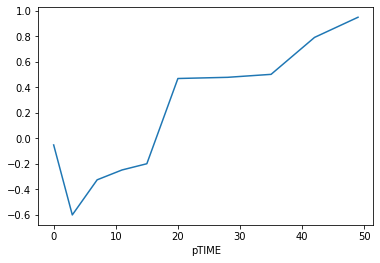

In [16]:
avg_dynamics.loc[56271].plot()#.to_csv('tmp/mouse_avg_dynamics_19ds.csv')


# Check tClock dynamics

In [58]:
avg = pd.read_csv('tmp/mouse_avg_dynamics_19ds.csv', index_col=0)
avg.index = list(map(str, avg.index.tolist()))

In [74]:
import joblib
model = joblib.load(open('clocks/Aging_mouse_norm.pkl', 'rb'))

In [75]:
genes = np.array(model.feature_names) #np.array(list(map(str, avg.index.tolist())))
wei = model.coef_
genes_ = genes[wei != 0]
wei_ = wei[wei != 0]

intsec = avg.index.intersection(genes_.tolist()).tolist()

In [76]:
avg.loc[intsec].to_csv('tmp/mouse_avg_dynamics_19ds_clock_selected.csv')

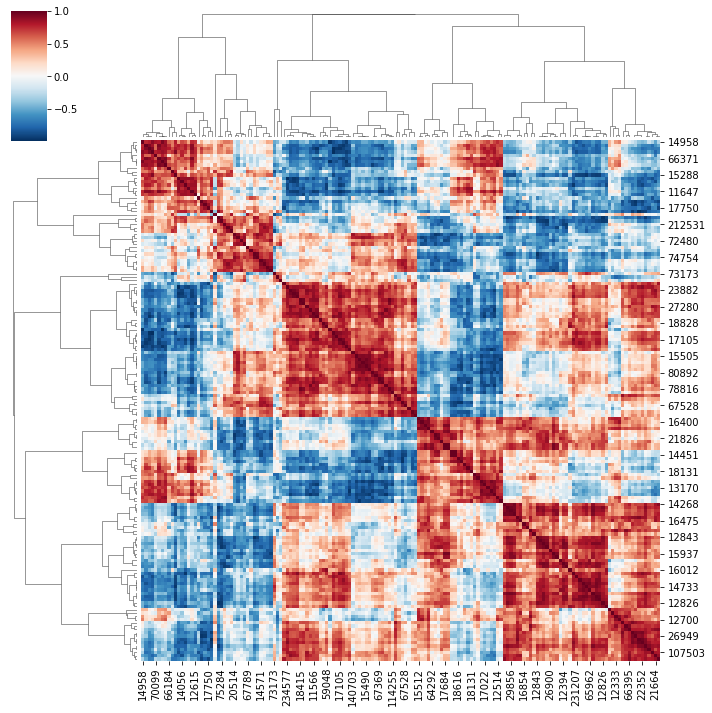

In [77]:
sns.clustermap(avg.loc[intsec].T.corr(), metric='correlation', method='complete', cmap='RdBu_r') 

# ???

In [9]:
h2m = pd.read_csv('utils/human2mouse_entrez.csv', index_col=0)

In [19]:
h2m_map = dict(zip(h2m['human'].values, h2m['mouse'].values))

In [54]:
cols = db.columns.map(h2m_map, na_action=np.nan)
cols = np.array(cols)
~np.isnan(list(cols))

array([ True,  True,  True, ..., False, False, False])

In [61]:
mouseEtz_db = db.T[~np.isnan(list(cols))].T
mouseEtz_db['TIME'] = db['TIME']

In [65]:
#mouseEtz_db.to_csv('data/human_full_data_12ds_mouse_etz.csv')

# Additional

In [59]:
df = pd.read_csv('clocks/Mouse_clock_output.csv', index_col=0)

In [60]:
tf = df

In [61]:
tf.Treatment.unique()

array(['OSKM', 'OSK', 'OK+9MS', 'C/EBPα+ OSKM', 'OSKM+dox_mef',
       '7F-Esrrb', '7F-Glis1', '7F-Jdp2', '7F-Kdm2b', '7F-Mkk6',
       '7F-Nanog', '7F-Sall4', '7F'], dtype=object)

In [62]:
tf

,ID,GEO,Treatment,Time,tAge_norm_mouseClock,tAge_scaled_mouseClock
GSE67462.OSKM.GSM1647454,GSE67462:OSKM,GSE67462,OSKM,0.0,0.152112,0.177560
GSE67462.OSKM.GSM1647455,GSE67462:OSKM,GSE67462,OSKM,0.0,0.131569,0.166540
GSE67462.OSKM.GSM1647456,GSE67462:OSKM,GSE67462,OSKM,1.0,0.108990,0.102617
GSE67462.OSKM.GSM1647457,GSE67462:OSKM,GSE67462,OSKM,1.0,0.106098,0.103676
GSE67462.OSKM.GSM1647458,GSE67462:OSKM,GSE67462,OSKM,3.0,0.072194,0.078807
...,...,...,...,...,...,...
GSE102348.OSKM.WT-1.GSM2735179,GSE102348:OSKM,GSE102348,OSKM,0.0,0.351655,0.425556
GSE102348.OSKM.WT-1.GSM2735180,GSE102348:OSKM,GSE102348,OSKM,2.0,0.395589,0.454813
GSE102348.OSKM.WT-1.GSM2735181,GSE102348:OSKM,GSE102348,OSKM,4.0,0.078564,0.154114
GSE102348.OSKM.WT-1.GSM2735182,GSE102348:OSKM,GSE102348,OSKM,6.0,0.222736,0.275356


In [63]:
import re
pattern = 'GSE\d+.(.*?).GSM'
S = tf.index.tolist()
treat = [re.search(pattern, s).group(1) for s in S]

mapper = {'OKMS':'OSKM'}
treat = [mapper[t] if t in mapper.keys() else t for t in treat ]

tf['Treatment'] = treat
tf['BatchTreatment'] = np.where(tf['Treatment'].str.contains('7F'), '7F', 'OSKM')

In [66]:
tf.to_csv('clocks/Mouse_clock_output.csv')